In [1]:
import numpy as np
import pandas as pd

from pycoingecko import CoinGeckoAPI

import matplotlib.pyplot as plt
%matplotlib inline


import statsmodels.graphics.tsaplots as sgt # plot acf, pacf
import statsmodels.tsa.stattools as sts # test of stationarity (adfuller)
from statsmodels.tsa.seasonal import seasonal_decompose # seasonality
from statsmodels.tsa.arima_model import ARIMA



## Data Acquisition

We start by initializing the Coingecko API from which we will retrieve our data

In [2]:
# COINGECKO API
cg = CoinGeckoAPI()

Let us start by retreiving the data for *Bitcoin*, the *USD coin* representing the US Dollar price and the *Thether-Gold* coin representing the gold price.

In [3]:
TOTAL_PERIOD = '100'
CURRENCY = 'eur'


bitcoin = cg.get_coin_market_chart_by_id(
    id = 'bitcoin',
    vs_currency = CURRENCY,
    days = TOTAL_PERIOD
)

usd_coin = cg.get_coin_market_chart_by_id(
    id = 'usd-coin',
    vs_currency = CURRENCY,
    days = TOTAL_PERIOD
)

gold_coin = cg.get_coin_market_chart_by_id(
    id = 'tether-gold',
    vs_currency = CURRENCY,
    days = TOTAL_PERIOD
)

Next, we organize the price data in data frames.

In [4]:
# CREATING DATAFRAMES
bitcoin_df = pd.DataFrame(bitcoin['prices'],columns=['time_stamp','price'])
usdc_df = pd.DataFrame(usd_coin['prices'],columns=['time_stamp','price'])
gold_df = pd.DataFrame(gold_coin['prices'],columns=['time_stamp','price'])

## Data Preprocesing

To get a feeling of our data, we look at the first few entries of the bitcoin data.
We also use info and describe method provided by pandas.

In [6]:
bitcoin_df.head()

,time_stamp,price
0,1708128000000,48405.756060
1,1708214400000,47958.580627
2,1708300800000,48348.852088
3,1708387200000,48043.597882
4,1708473600000,48367.898536


In [5]:
bitcoin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   time_stamp  100 non-null    int64  
 1   price       100 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 1.7 KB


In [7]:
bitcoin_df.describe()

,time_stamp,price
count,1.000000e+02,100.000000
mean,1.712405e+12,59646.689893
std,2.506700e+09,5019.251043
min,1.708128e+12,46933.944013
25%,1.710266e+12,57678.423266
50%,1.712405e+12,60377.470430
75%,1.714543e+12,63137.644914
max,1.716688e+12,66750.176232


When working with time series, it is customary to work with the *datetime*-type. 
We hence correct the data type of the *time_stamp* column accordingly.

In [8]:
bitcoin_df['date'] = pd.to_datetime(bitcoin_df.time_stamp,unit='ms')
usdc_df['date'] = pd.to_datetime(usdc_df.time_stamp,unit='ms')
gold_df['date'] = pd.to_datetime(gold_df.time_stamp,unit='ms')

Next, let us create new data frames grouped by the actual date (automatically formated YYYY-MM-DD by calling the `df.dt.date` attribute) and aggragated along the price for the minimal value *min*, the maximal value *max*, the opening value *first* and the closing value *last* of the correspinding day.

In [9]:
# GROUPBY DATE (Y-M-D) AND AGGREGATE PRICE BY MIN, MAX, FIRST (OPEN), LAST (CLOSE)
btc = bitcoin_df.groupby(bitcoin_df.date.dt.date).agg({'price':['min','max','first','last']})
usdc = usdc_df.groupby(usdc_df.date.dt.date).agg({'price':['min','max','first','last']})
gold = gold_df.groupby(gold_df.date.dt.date).agg({'price':['min','max','first','last']})

For convenience, we prefer not to work with multi-indices at this point and hence we redefine the data frame to get rid of the multi-index

In [10]:
btc = btc.price
usdc = usdc.price
gold = gold.price

As we are interested in daily prices and returns, we will set the frequency to *daily*

In [12]:
for coin in [btc,usdc,gold]:
    coin.asfreq('d')

Let us now check for missing data...

In [13]:
# CHECK FOR MISSING DATA
print(f'btc missing data:\n{btc.isna().sum()}\n')
print(f'usdc missing data:\n{usdc.isna().sum()}\n')
print(f'gold missing data:\n{gold.isna().sum()}')

btc missing data:
min      0
max      0
first    0
last     0
dtype: int64

usdc missing data:
min      0
max      0
first    0
last     0
dtype: int64

gold missing data:
min      0
max      0
first    0
last     0
dtype: int64


... none found. Great!

From now on, we will be focusing on the closing prices and returns.
Let us therefore add returns for the closing prices (*last*) using pandas `df.pct_change()` method.

In [16]:
# ADDING RETURNS OF CLOSE
for coin in [btc,usdc,gold]:
    coin['ret_close'] = coin['last'].pct_change()


Finally, we condense the closing prices and returns into new data frames which we will use for all further analysis. 

In [17]:
# DEFINE DATA FRAMES FOR CLOSING PRICES AND RETURNS
btc_close = btc[['last','ret_close']].rename(columns={'last':'closing_price','ret_close':'closing_ret'})
usdc_close = usdc[['last','ret_close']].rename(columns={'last':'closing_price','ret_close':'closing_ret'})
gold_close = gold[['last','ret_close']].rename(columns={'last':'closing_price','ret_close':'closing_ret'})


A word of caution: if you look at the data frames for closing prices and returns, you will notice that the returns column contains a **NaN** value in its first entry. That is to be expected from how the `pct_change()` method works. 

Instead of filling the value, or dropping this row, we will keep it as it is to avoid losing data for the prices. 
However, we will keep in minnd that when working with returns, we will work omit the missing value, by using  `df.iloc[1:]`.

## Exploration of data

After having cleaned our data, let us have a qucik look at them.

### Prices

Text(0.5, 1.0, 'btc price')

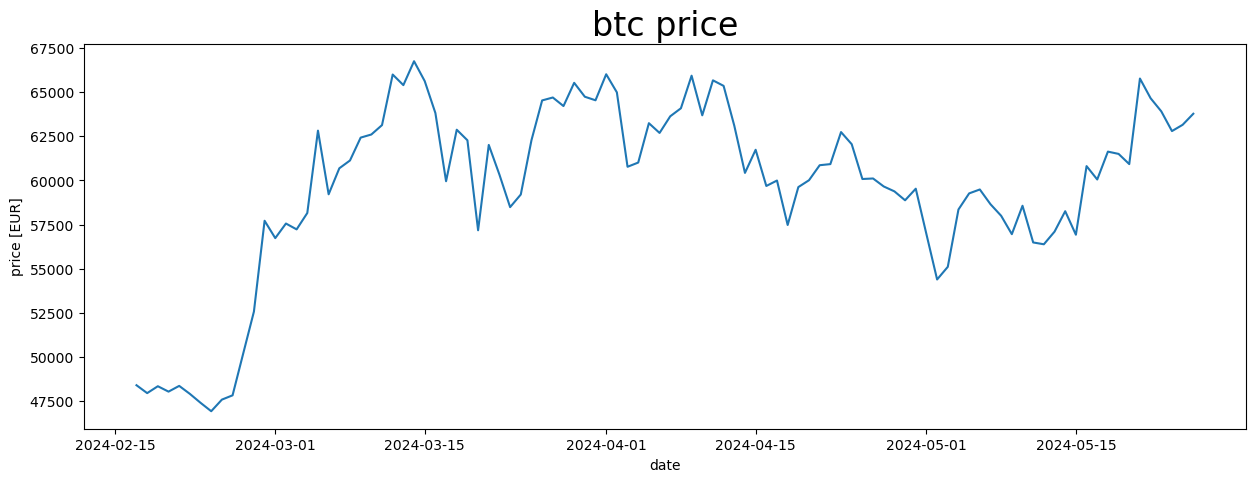

In [19]:
ax = btc_close.closing_price.plot(figsize=(15,5))
ax.set_ylabel('price [EUR]')
plt.title('btc price',fontsize=24)

Text(0.5, 1.0, 'usdc price')

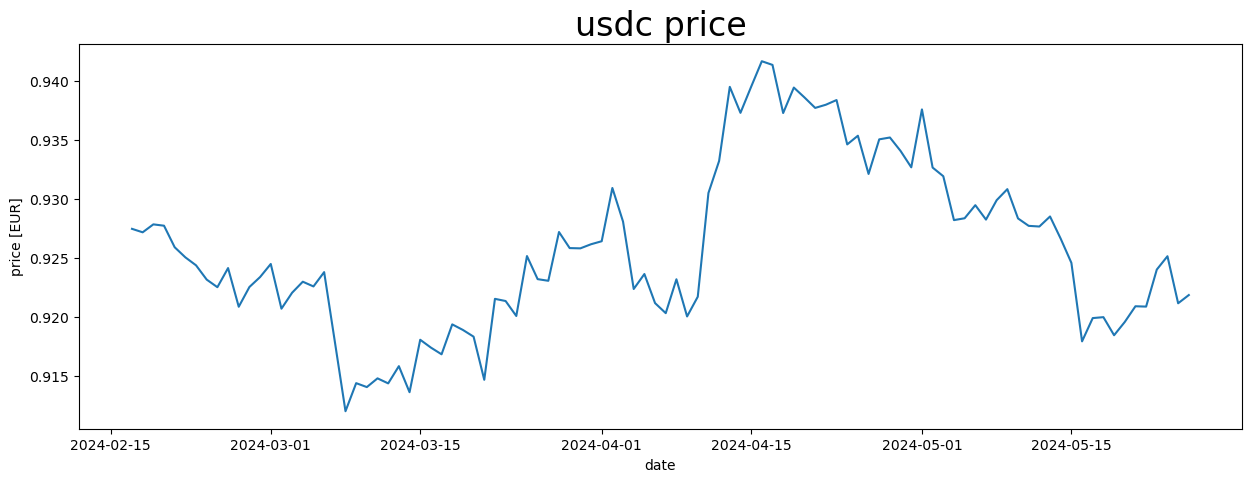

In [18]:
ax = usdc_close.closing_price.plot(figsize=(15,5))
ax.set_ylabel('price [EUR]')
plt.title('usdc price',fontsize=24)

Text(0.5, 1.0, 'gold price')

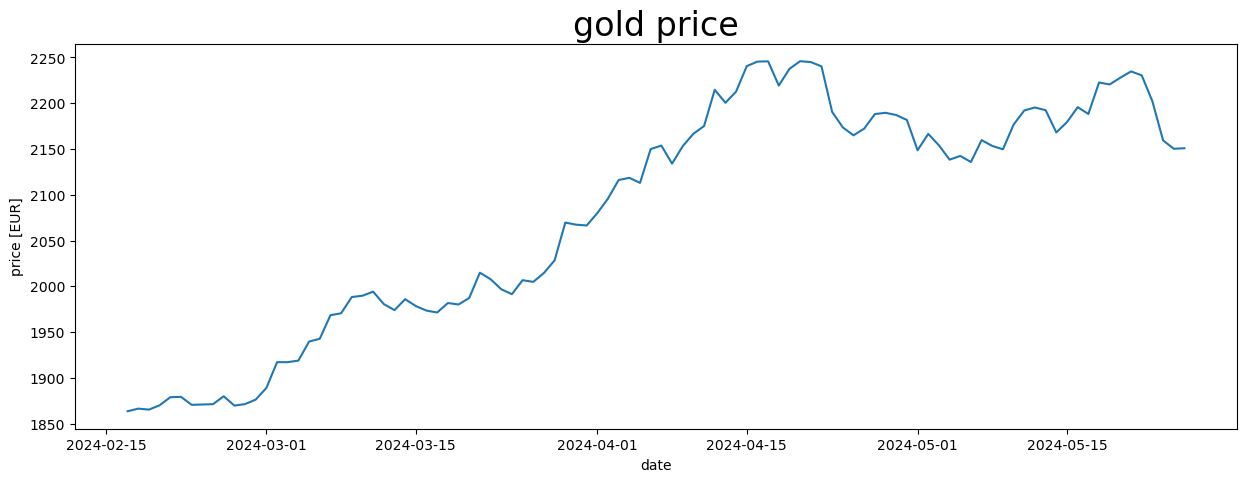

In [146]:
ax = gold_close.closing_price.plot(figsize=(15,5))
ax.set_ylabel('price [EUR]')
plt.title('gold price',fontsize=24)

The three plots display the fluctuating behavior of Bitcoin (btc), the US Dollar (usdc) and of Gold (gold) fairly well. Here we use the Euro (EUR) as a baseline.

In order to get a better feel of the stability, i.e. of the fluctuating behavior of the prices, we normalise each one according to their maximum and display them all in one plot for better comparison.

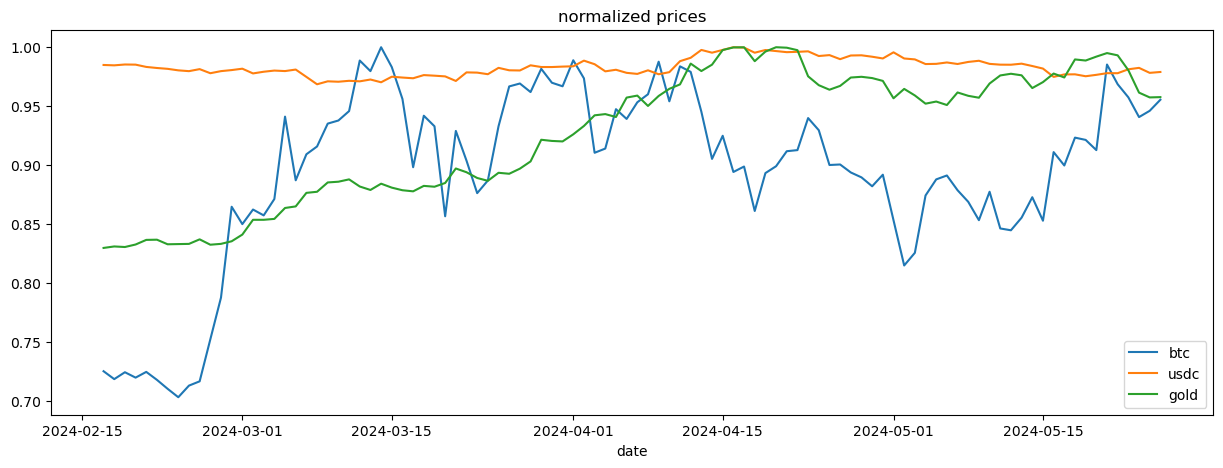

In [20]:
# NORMALIZED (BY MAX) PRICES
fig = plt.figure(figsize=(15,5))
btc_close.closing_price.div(btc_close.closing_price.max()).plot(label='btc')
usdc_close.closing_price.div(usdc_close.closing_price.max()).plot(label='usdc')
gold_close.closing_price.div(gold_close.closing_price.max()).plot(label='gold')

plt.title('normalized prices')
plt.legend()

As one might have expected from experience, the largest fluctuations seem to be inherent to Bitcoin, while the US Dollar price seems to be farily stable.

### Returns

Returns tend to be more stable than prices, so let's have a look at the returns.

Text(0.5, 1.0, 'returns')

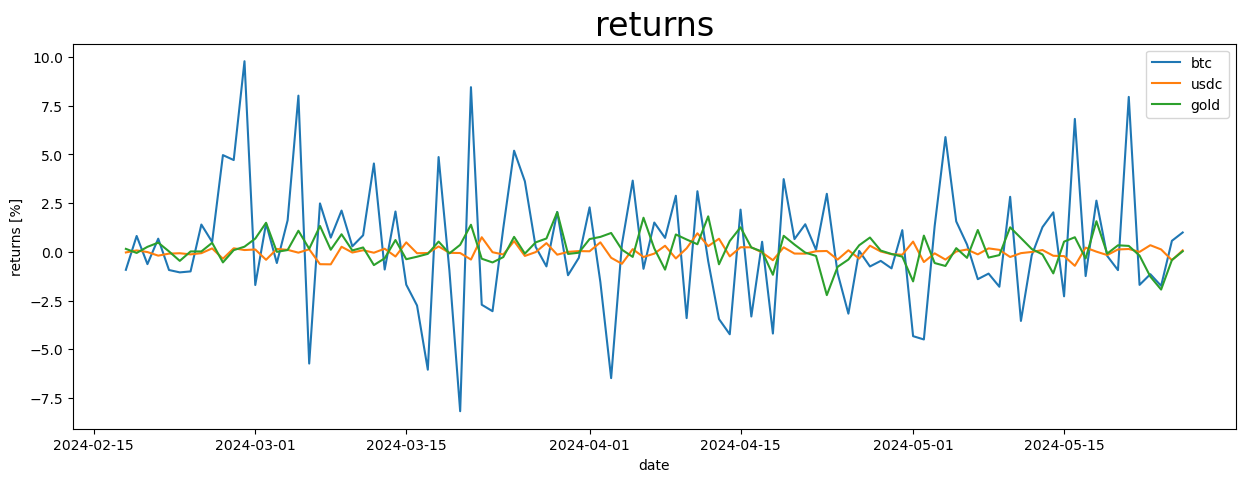

In [21]:
fig, ax = plt.subplots(figsize=(15,5))
btc_close.closing_ret[1:].mul(100).plot(figsize=(15,5),label='btc')
usdc_close.closing_ret[1:].mul(100).plot(figsize=(15,5),label='usdc')
gold_close.closing_ret[1:].mul(100).plot(figsize=(15,5),label='gold')
ax.set_ylabel('returns [%]')
plt.legend()
plt.title('returns',fontsize=24)

We observe the same behavior as for the prices; the returns of Bitcoin fluctauate the most.
In fact, the Bitcoin returns fluctuate greatly, with up to 10%.

## Timeseries Analysis

Text(0.5, 1.0, 'PACF btc price')

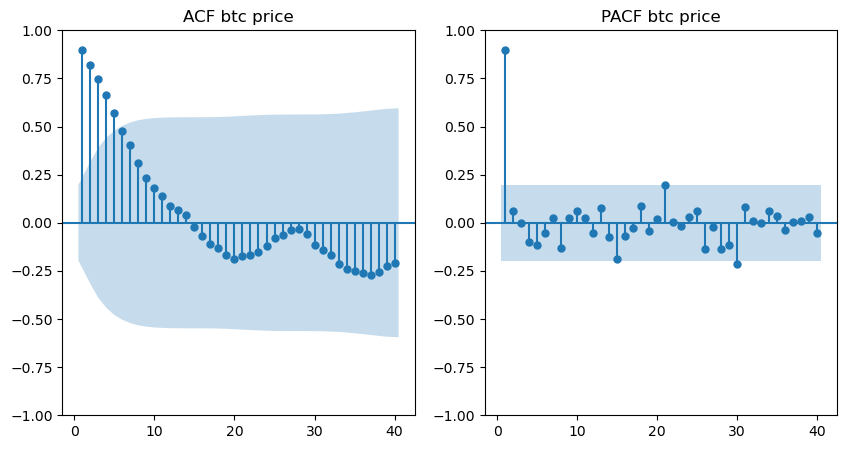

In [183]:
# STATIONARITY
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))

sgt.plot_acf(btc_close.closing_price,ax=ax[0],lags = 40, zero=False)
ax[0].set_title('ACF btc price')
sgt.plot_pacf(btc_close.closing_price,ax=ax[1],lags= 40, zero=False)
ax[1].set_title('PACF btc price')


Text(0.5, 1.0, 'PACF btc returns')

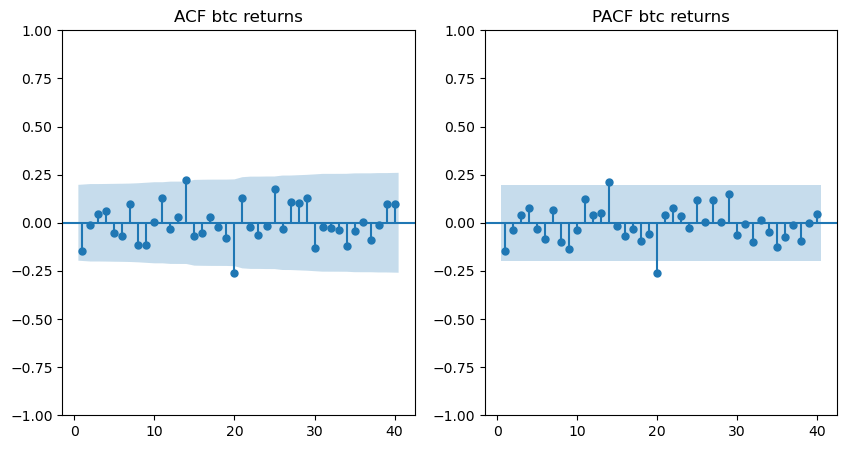

In [185]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
sgt.plot_acf(btc_close.closing_ret[1:],ax=ax[0],lags = 40, zero=False)
ax[0].set_title('ACF btc returns')
sgt.plot_pacf(btc_close.closing_ret[1:],ax=ax[1],lags = 40, zero=False)
ax[1].set_title('PACF btc returns')

In [186]:
sts.adfuller(btc_close.closing_ret[1:]) # STATIONARY

(-11.366596673022443,
 9.194305786866166e-21,
 0,
 98,
 {'1%': -3.4989097606014496,
  '5%': -2.891516256916761,
  '10%': -2.5827604414827157},
 -351.05223657873034)

# Climate Data

In [5]:
data = xr.open_dataset('./Medium_data.nc')
data

<xarray.Dataset> Size: 1MB
Dimensions:    (longitude: 2, latitude: 2, time: 8760)
Coordinates:
  * longitude  (longitude) float32 8B 101.5 101.8
  * latitude   (latitude) float32 8B 52.75 52.5
  * time       (time) datetime64[ns] 70kB 2023-01-01 ... 2023-12-31T23:00:00
Data variables:
    t2m        (time, latitude, longitude) float64 280kB ...
    tp         (time, latitude, longitude) float64 280kB ...
    sp         (time, latitude, longitude) float64 280kB ...
    ssr        (time, latitude, longitude) float64 280kB ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-04-16 11:11:12 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [10]:
df = data.sel(latitude=52.53, longitude=101.63, method='pad').to_pandas().drop(['latitude', 'longitude'], axis=1)
df2 = data.to_dataframe()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2023-01-01 00:00:00 to 2023-12-31 23:00:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   t2m     8760 non-null   float64
 1   tp      8760 non-null   float64
 2   sp      8760 non-null   float64
 3   ssr     8760 non-null   float64
dtypes: float64(4)
memory usage: 342.2 KB


In [8]:
df.head()

,t2m,tp,sp,ssr
time,,,,
2023-01-01 00:00:00,240.185619,4.336809e-19,89905.091785,0.000000
2023-01-01 01:00:00,240.286190,4.336809e-19,89948.194840,0.000000
2023-01-01 02:00:00,241.529916,4.336809e-19,89900.941120,13952.470725
2023-01-01 03:00:00,243.476521,4.336809e-19,89944.682739,163897.377627
2023-01-01 04:00:00,244.894570,4.336809e-19,89860.232680,342586.140357


In [11]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 35040 entries, (101.5, 52.75, Timestamp('2023-01-01 00:00:00')) to (101.75, 52.5, Timestamp('2023-12-31 23:00:00'))
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   t2m     35040 non-null  float64
 1   tp      35040 non-null  float64
 2   sp      35040 non-null  float64
 3   ssr     35040 non-null  float64
dtypes: float64(4)
memory usage: 1.5 MB


In [40]:
long = 101.5
latt = 52.5
df = df2.loc[long, latt]

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2023-01-01 00:00:00 to 2023-12-31 23:00:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   t2m     8760 non-null   float64
 1   tp      8760 non-null   float64
 2   sp      8760 non-null   float64
 3   ssr     8760 non-null   float64
dtypes: float64(4)
memory usage: 342.2 KB


In [42]:
df.shape

(8760, 4)

In [71]:
df.reset_index()['time'][2].month

1

In [83]:
df['t2m'].head()

time
2023-01-01 00:00:00    242.190331
2023-01-01 01:00:00    242.454050
2023-01-01 02:00:00    243.801700
2023-01-01 03:00:00    245.357196
2023-01-01 04:00:00    246.396428
Name: t2m, dtype: float64

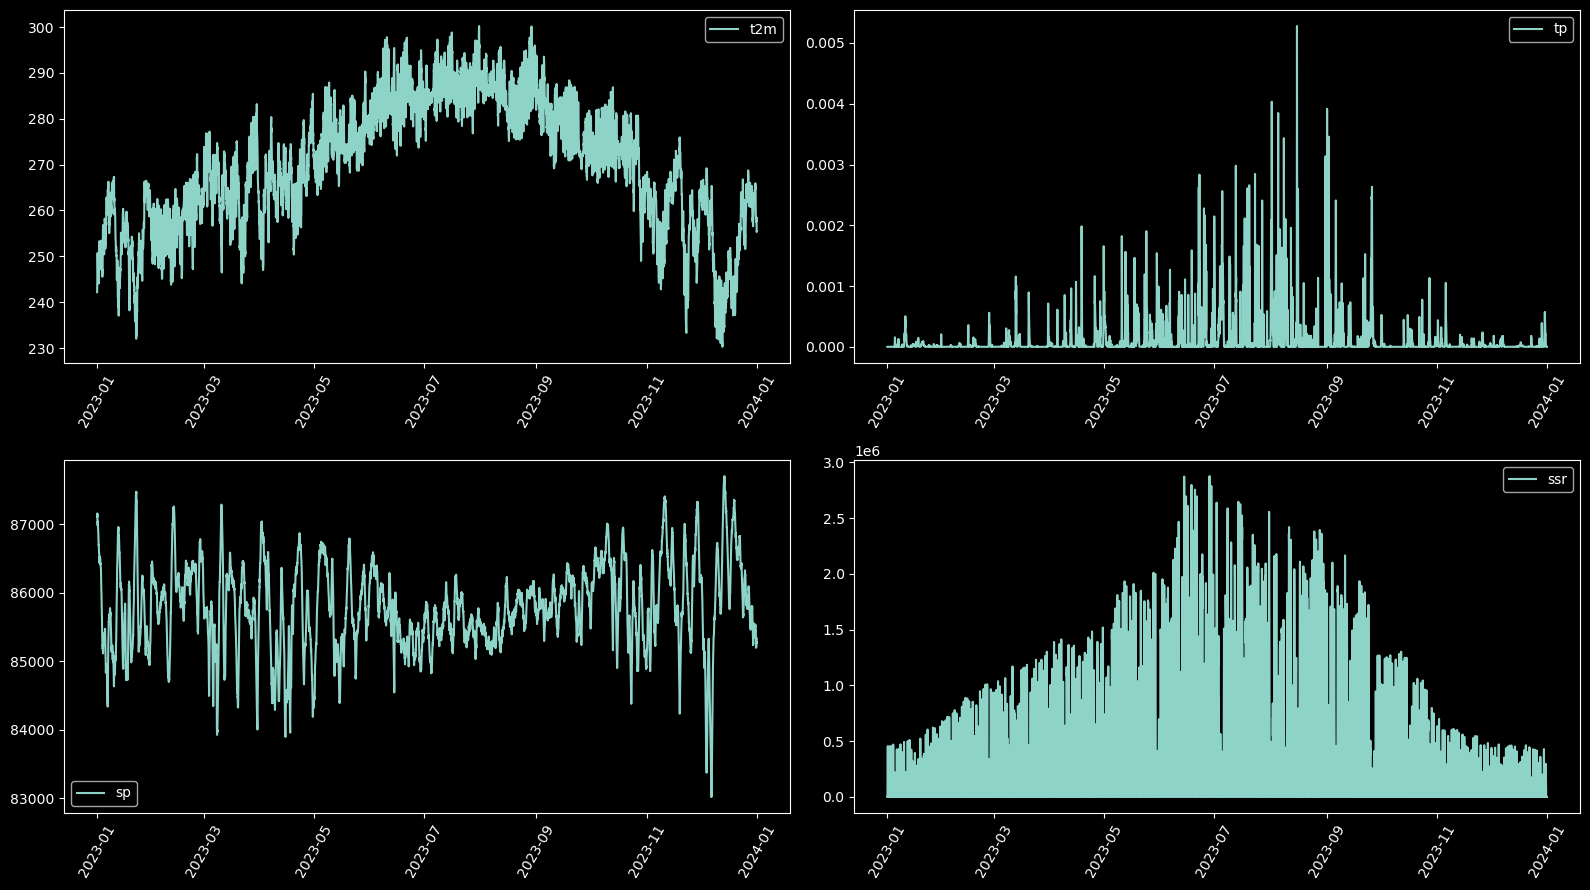

In [80]:
fig = plt.figure(figsize=(16,9))
title = ['temp','total precipitation','surface pressure','surface solar radiation']


for i,col in enumerate(df.columns):
    plt.subplot(2,2,i+1)
    plt.plot(df[col],label=col)
    plt.xticks(rotation=60)
    plt.legend()

plt.tight_layout()
    